In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
from matplotlib import font_manager, rc
font_path= 'C:/Windows/Fonts/NGULIM.TTF'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

#### 통합 데이터 불러오기

In [3]:
df = pd.read_csv('../data_2/full형매변환.csv') 
print(df.shape)

df_copy = df.copy()

# 일단 농가 결측치는 제거
df_copy.dropna(subset=['농가근내평균'], inplace=True)
print(df_copy.shape)

# 형매 결측치 0채우기
print(df_copy.isna().sum())
df_copy['형매_bi'].fillna('3마리미만', inplace=True) # 안 하고 하면 형매bi도 0 채워짐
df_copy.fillna(0, inplace=True)
print('=====')
print(f"결측치 총 개수:{df_copy.isna().sum(axis=1).sum()}")
print(df_copy.형매_bi.value_counts())

(99848, 19)
(76307, 19)
개월령              0
생시체중             0
근내평균             0
도체범위근내평균         0
체고               0
체장               0
형매도축수        55263
형매도체평균       55263
형매근내평균       55263
형매근내평균가산     55263
출산여부_6개월내        0
농가근내평균           0
농가근내평균가산         0
근내EPD            0
근내               0
점수               0
농가구분             0
TARGET1          0
형매_bi        55263
dtype: int64
=====
결측치 총 개수:0
3마리미만    65623
3마리이상    10684
Name: 형매_bi, dtype: int64


#### TARGET2 만들기

In [4]:
df_copy['TARGET2'] = df_copy['점수'].apply(lambda x: 1 if 4<=x else 0 if 4 > x else 0)
print(df_copy['TARGET2'].value_counts())
print(df_copy['점수'].value_counts())

0    48067
1    28240
Name: TARGET2, dtype: int64
3    22666
2    21245
4    17241
5    10999
1     4026
0      130
Name: 점수, dtype: int64


##### train_test_split 7:3

In [5]:
print(f"체고 0 인거:{df_copy[df_copy['체고']==0]}")

체고 0 인거:Empty DataFrame
Columns: [개월령, 생시체중, 근내평균, 도체범위근내평균, 체고, 체장, 형매도축수, 형매도체평균, 형매근내평균, 형매근내평균가산, 출산여부_6개월내, 농가근내평균, 농가근내평균가산, 근내EPD, 근내, 점수, 농가구분, TARGET1, 형매_bi, TARGET2]
Index: []


In [6]:
from sklearn.model_selection import train_test_split

X = df_copy.drop(['TARGET1'],axis=1)
Y = df_copy.TARGET1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 2023)

print(f'데이터 셋 70%:{df_copy.shape[0]*0.7}')
print(f'데이터 셋 30%:{df_copy.shape[0]*0.3}')

train = pd.concat([X_train,Y_train], axis=1)
test = pd.concat([X_test,Y_test], axis=1)

print(f'train set:{train.shape[0]}')
print(f'test set:{test.shape[0]}')

데이터 셋 70%:53414.899999999994
데이터 셋 30%:22892.1
train set:53414
test set:22893


In [7]:
model = sm.Logit.from_formula(""" TARGET2 ~ 개월령+ 생시체중+ 
근내평균+도체범위근내평균+체고+체장+C(형매_bi, Treatment("3마리이상"))+형매도체평균+
형매근내평균+형매근내평균가산+C(출산여부_6개월내, Treatment("Y"))
+농가근내평균+농가근내평균가산+근내EPD
+C(농가구분, Treatment("농가소")) """, train).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.542988
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                TARGET2   No. Observations:                53414
Model:                          Logit   Df Residuals:                    53398
Method:                           MLE   Df Model:                           15
Date:                Mon, 06 Nov 2023   Pseudo R-squ.:                  0.1757
Time:                        22:42:06   Log-Likelihood:                -29003.
converged:                       True   LL-Null:                       -35183.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -4.3135      0.570     -7.572      0.000      -5.430      -3.197
C(형매_bi, Treatment("3마리이상"))[T.3마리미만]     0.0378      0.040      0.952      0.341      -0.040       0.116
C(출산여부_6개월내, Treatment("Y"))[T.N]         0.2172      0.024      8.933      0.000       0.170       0.265
C(농가구분, Treatment("농가소"))[T.우시장소]         0.2779      0.040      6.882      0.000       0.199       0.357
개월령                                      -0.0009      0.001     -0.672      0.502      -0.004       0.002
생시체중                                      0.0015      0.000      8.971      0.000       0.001       0.002
근내평균                                      0.1316      0.028      4.621      0.000       0.076       0.187
도체범위근내평균                                  0.6984      0.022     31.759      0.000       0.655       0.742
체고                                       -0.0150      0.006     -2.669      0.008      -0.026      -0.004
체장                                        0.0020      0.003      0.704      0.482      -0.004       0.008
형매도체평균                                   -0.0026      0.000     -6.049      0.000      -0.003      -0.002
형매근내평균                                    0.1690      0.033      5.048      0.000       0.103       0.235
형매근내평균가산                                  0.0980      0.035      2.819      0.005       0.030       0.166
농가근내평균                                    0.0470      0.016      3.029      0.002       0.017       0.077
농가근내평균가산                                  0.4170      0.019     21.763      0.000       0.379       0.455
근내EPD                                     0.5861      0.053     11.018      0.000       0.482       0.690
=========================================================================================================
"""

In [8]:
odds_ratios = pd.DataFrame(
    {
        "OR": model.params,
        "Lower CI": model.conf_int()[0],
        "Upper CI": model.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios

,OR,Lower CI,Upper CI
Intercept,0.013387,0.004383,0.040887
"C(형매_bi, Treatment(""3마리이상""))[T.3마리미만]",1.038527,0.960777,1.122568
"C(출산여부_6개월내, Treatment(""Y""))[T.N]",1.242600,1.184773,1.303249
"C(농가구분, Treatment(""농가소""))[T.우시장소]",1.320380,1.219895,1.429142
개월령,0.999070,0.996363,1.001785
생시체중,1.001551,1.001212,1.001890
근내평균,1.140687,1.078754,1.206175
도체범위근내평균,2.010589,1.925770,2.099144
체고,0.985114,0.974325,0.996022
체장,1.001998,0.996443,1.007585


In [9]:
model = sm.Logit.from_formula(""" TARGET1 ~ 생시체중+ 
근내평균+도체범위근내평균+체고+형매도체평균+
형매근내평균가산+C(출산여부_6개월내, Treatment("Y"))+
농가근내평균+농가근내평균가산+근내EPD
+C(농가구분, Treatment("농가소")) """, train).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.336621
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                TARGET1   No. Observations:                53414
Model:                          Logit   Df Residuals:                    53402
Method:                           MLE   Df Model:                           11
Date:                Mon, 06 Nov 2023   Pseudo R-squ.:                  0.1824
Time:                        22:42:07   Log-Likelihood:                -17980.
converged:                       True   LL-Null:                       -21991.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -6.1697      0.741     -8.323      0.000      -7.623      -4.717
C(출산여부_6개월내, Treatment("Y"))[T.N]     0.3824      0.029     13.252      0.000       0.326       0.439
C(농가구분, Treatment("농가소"))[T.우시장소]     0.2450      0.054      4.520      0.000       0.139       0.351
생시체중                                  0.0008      0.000      3.500      0.000       0.000       0.001
근내평균                                  0.1423      0.037      3.816      0.000       0.069       0.215
도체범위근내평균                              0.7695      0.029     26.378      0.000       0.712       0.827
체고                                   -0.0096      0.006     -1.699      0.089      -0.021       0.001
형매도체평균                               -0.0007   7.82e-05     -8.582      0.000      -0.001      -0.001
형매근내평균가산                              0.2698      0.023     11.736      0.000       0.225       0.315
농가근내평균                                0.0314      0.021      1.512      0.131      -0.009       0.072
농가근내평균가산                              0.4771      0.025     18.865      0.000       0.428       0.527
근내EPD                                 0.6313      0.068      9.283      0.000       0.498       0.765
=====================================================================================================
"""

In [10]:
odds_ratios = pd.DataFrame(
    {
        "OR": model.params,
        "Lower CI": model.conf_int()[0],
        "Upper CI": model.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios

,OR,Lower CI,Upper CI
Intercept,0.002092,0.000489,0.008944
"C(출산여부_6개월내, Treatment(""Y""))[T.N]",1.465832,1.385226,1.551128
"C(농가구분, Treatment(""농가소""))[T.우시장소]",1.277645,1.148865,1.420861
생시체중,1.000797,1.000351,1.001243
근내평균,1.152902,1.071648,1.240317
도체범위근내평균,2.158770,2.038797,2.285803
체고,0.990418,0.979474,1.001483
형매도체평균,0.999329,0.999176,0.999482
형매근내평균가산,1.309735,1.252025,1.370105
농가근내평균,1.031859,0.990745,1.074678


#### 유의한 변수만 고르기

In [11]:
model = sm.Logit.from_formula(""" TARGET2 ~ 생시체중+ 근내평균 +도체범위근내평균 + 형매도체평균
                              + 형매근내평균가산 + C(출산여부_6개월내, Treatment("Y"))
                              + 농가근내평균가산 + 근내EPD
                              + C(농가구분, Treatment("농가소")) """, train).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.543409
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                TARGET2   No. Observations:                53414
Model:                          Logit   Df Residuals:                    53404
Method:                           MLE   Df Model:                            9
Date:                Mon, 06 Nov 2023   Pseudo R-squ.:                  0.1750
Time:                        22:42:08   Log-Likelihood:                -29026.
converged:                       True   LL-Null:                       -35183.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -5.7131      0.138    -41.468      0.000      -5.983      -5.443
C(출산여부_6개월내, Treatment("Y"))[T.N]     0.2276      0.021     10.706      0.000       0.186       0.269
C(농가구분, Treatment("농가소"))[T.우시장소]     0.2618      0.040      6.536      0.000       0.183       0.340
생시체중                                  0.0014      0.000      8.461      0.000       0.001       0.002
근내평균                                  0.1327      0.028      4.801      0.000       0.079       0.187
도체범위근내평균                              0.7080      0.022     32.530      0.000       0.665       0.751
형매도체평균                               -0.0005   5.49e-05     -9.656      0.000      -0.001      -0.000
형매근내평균가산                              0.2553      0.016     15.683      0.000       0.223       0.287
농가근내평균가산                              0.4657      0.011     42.351      0.000       0.444       0.487
근내EPD                                 0.5842      0.052     11.247      0.000       0.482       0.686
=====================================================================================================
"""

In [12]:
train_copy = train.copy()

pred_y_1 = model.predict(train)

train_copy['probability_tr'] = pred_y_1

print(len(train_copy))
train_copy.head()

53414


,개월령,생시체중,근내평균,도체범위근내평균,체고,체장,형매도축수,형매도체평균,형매근내평균,형매근내평균가산,...,농가근내평균,농가근내평균가산,근내EPD,근내,점수,농가구분,형매_bi,TARGET2,TARGET1,probability_tr
74658,51,632.14,2.50,2.40,131.1,152.9,0.0,0.00,0.0,0.00,...,4.44,-0.50,-0.03,3,2,농가소,3마리미만,0,0,0.045979
47151,38,748.21,5.00,5.58,132.7,158.0,0.0,0.00,0.0,0.00,...,5.67,-0.68,0.29,7,5,농가소,3마리미만,1,1,0.454905
65363,50,737.50,4.19,5.67,129.2,137.1,6.0,377.17,5.0,0.04,...,5.31,1.13,-0.04,7,4,농가소,3마리이상,1,0,0.554891
73951,50,867.86,5.12,6.00,129.9,146.7,0.0,0.00,0.0,0.00,...,5.84,0.48,0.42,8,5,농가소,3마리미만,1,1,0.714818
64019,54,671.43,4.51,4.72,128.1,147.4,0.0,0.00,0.0,0.00,...,4.73,-0.57,0.06,3,2,농가소,3마리미만,0,0,0.259754


In [13]:
# train set 만들기
test_copy = test.copy()

pred_y = model.predict(test_copy)

test_copy['probability'] = pred_y

print(len(test_copy))
test_copy.head()

22893


,개월령,생시체중,근내평균,도체범위근내평균,체고,체장,형매도축수,형매도체평균,형매근내평균,형매근내평균가산,...,농가근내평균,농가근내평균가산,근내EPD,근내,점수,농가구분,형매_bi,TARGET2,TARGET1,probability
24682,58,692.86,4.16,4.54,131.3,154.1,0.0,0.0,0.0,0.00,...,4.67,0.28,0.08,6,4,농가소,3마리미만,1,0,0.364595
99156,48,695.00,5.22,5.33,128.6,149.9,0.0,0.0,0.0,0.00,...,5.67,0.49,0.34,8,5,우시장소,3마리미만,1,1,0.659052
29604,33,650.00,4.93,5.14,125.8,143.9,0.0,0.0,0.0,0.00,...,4.43,-0.62,0.23,6,4,농가소,3마리미만,1,0,0.396284
4970,44,825.00,4.89,5.82,134.9,157.6,0.0,0.0,0.0,0.00,...,4.42,0.06,0.49,7,5,농가소,3마리미만,1,1,0.633027
98627,30,524.00,4.78,3.80,125.8,143.9,3.0,458.0,4.0,-1.81,...,6.00,1.52,0.06,4,3,우시장소,3마리이상,0,0,0.207096


In [14]:
from performance import performance

In [15]:
train_copy['prob_5'] = train_copy['probability_tr'].apply(lambda x: 1 if 0.5<= x else 0 if 0<x<5 else x)
train_copy['prob_6'] = train_copy['probability_tr'].apply(lambda x: 1 if 0.6<= x else 0 if 0<x<6 else x)
train_copy['prob_7'] = train_copy['probability_tr'].apply(lambda x: 1 if 0.7<= x else 0 if 0<x<7 else x)
train_copy['prob_8'] = train_copy['probability_tr'].apply(lambda x: 1 if 0.8<= x else 0 if 0<x<8 else x)
train_copy['prob_9'] = train_copy['probability_tr'].apply(lambda x: 1 if 0.9<= x else 0 if 0<x<9 else x)

train_copy['prob_85'] = train_copy['probability_tr'].apply(lambda x: 1 if 0.85<= x else 0 if 0<x<85 else x)


In [16]:
test_copy['prob_5'] = test_copy['probability'].apply(lambda x: 1 if 0.5<= x else 0 if 0<x<5 else x)
test_copy['prob_6'] = test_copy['probability'].apply(lambda x: 1 if 0.6<= x else 0 if 0<x<6 else x)
test_copy['prob_7'] = test_copy['probability'].apply(lambda x: 1 if 0.7<= x else 0 if 0<x<7 else x)
test_copy['prob_8'] = test_copy['probability'].apply(lambda x: 1 if 0.8<= x else 0 if 0<x<8 else x)
test_copy['prob_9'] = test_copy['probability'].apply(lambda x: 1 if 0.9<= x else 0 if 0<x<9 else x)

test_copy['prob_85'] = test_copy['probability'].apply(lambda x: 1 if 0.85<= x else 0 if 0<x<85 else x)

In [17]:
print(len(test_copy[test_copy['prob_5'].isnull()==False]))
print(len(test_copy[test_copy['prob_6'].isnull()==False]))
print(len(test_copy[test_copy['prob_7'].isnull()==False]))
print(len(test_copy[test_copy['prob_8'].isnull()==False]))
print(len(test_copy[test_copy['prob_9'].isnull()==False]))

22893
22893
22893
22893
22893


In [18]:
print(f"4이상개수:{len(test_copy[test_copy['점수']>=4])}")
print(f"TARGET1개수:{len(test_copy[test_copy['TARGET2']==1])}")
print('========================================='*2)
print(f"0.5이상개수:{len(test_copy[test_copy['probability']>=0.5])}")
print(f"prob_5개수:{len(test_copy[test_copy['prob_5']==1])}")
print('========================================='*2)
print(f"0.6이상개수:{len(test_copy[test_copy['probability']>=0.6])}")
print(f"prob_6개수:{len(test_copy[test_copy['prob_6']==1])}")
print('========================================='*2)
print(f"0.7이상개수:{len(test_copy[test_copy['probability']>=0.7])}")
print(f"prob_7개수:{len(test_copy[test_copy['prob_7']==1])}")
print('========================================='*2)
print(f"0.8이상개수:{len(test_copy[test_copy['probability']>=0.8])}")
print(f"prob_8개수:{len(test_copy[test_copy['prob_8']==1])}")
print('========================================='*2)
print(f"0.9이상개수:{len(test_copy[test_copy['probability']>=0.9])}")
print(f"prob_9개수:{len(test_copy[test_copy['prob_9']==1])}")

4이상개수:8503
TARGET1개수:8503
0.5이상개수:6566
prob_5개수:6566
0.6이상개수:4196
prob_6개수:4196
0.7이상개수:2221
prob_7개수:2221
0.8이상개수:920
prob_8개수:920
0.9이상개수:154
prob_9개수:154


In [31]:
test_copy.to_excel('../result/result_45.xlsx')

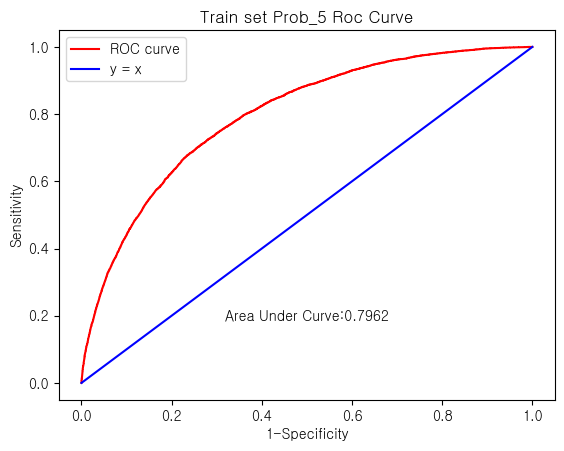

In [19]:
# roc curve, auc train set
fpr, tpr, thresholds = roc_curve(train_copy['TARGET1'], train_copy['probability_tr'])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(train_copy['TARGET1'], train_copy['probability_tr'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('Train set Prob_5 Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

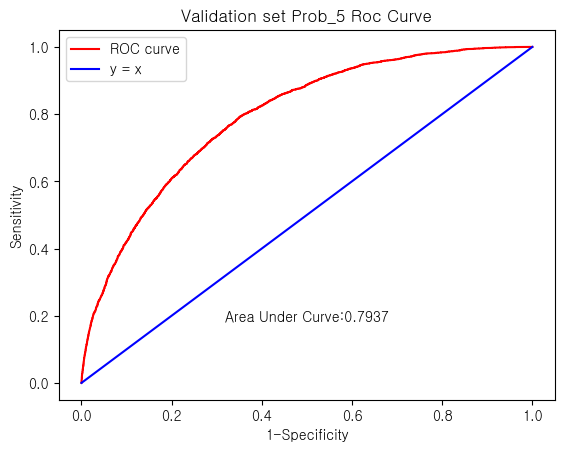

In [20]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(test_copy['TARGET1'], test_copy['probability'])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(test_copy['TARGET1'], test_copy['probability'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('Validation set Prob_5 Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

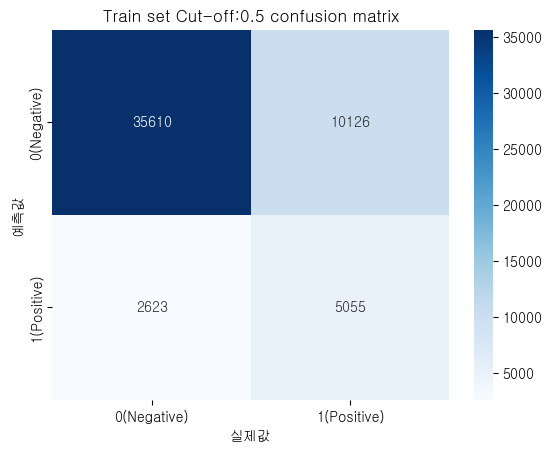

True Positive:5055
True Negative:35610
False Positive:10126
False Negative:2623


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,65.837458,64.776633,66.898282
1,Specificity,77.859892,77.479375,78.240408
2,Accuracy,76.131726,75.770214,76.493237
3,PPV,33.298202,32.548506,34.047897
4,NPV,93.139435,92.886048,93.392821
5,F_0.5_score,36.950674,NaN,NaN


In [21]:
# cut-off 0.5 train set
cm = confusion_matrix(train_copy['TARGET1'],train_copy['prob_5'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Train set Cut-off:0.5 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(train_copy[(train_copy['prob_5']==1)&(train_copy['TARGET1']==1)])}")
print(f"True Negative:{len(train_copy[(train_copy['prob_5']==0)&(train_copy['TARGET1']==0)])}")
print(f"False Positive:{len(train_copy[(train_copy['prob_5']==1)&(train_copy['TARGET1']==0)])}")
print(f"False Negative:{len(train_copy[(train_copy['prob_5']==0)&(train_copy['TARGET1']==1)])}")

performance(TP=len(train_copy[(train_copy['prob_5']==1)&(train_copy['TARGET1']==1)]),
            TN=len(train_copy[(train_copy['prob_5']==0)&(train_copy['TARGET1']==0)]),
            FP=len(train_copy[(train_copy['prob_5']==1)&(train_copy['TARGET1']==0)]),
            FN=len(train_copy[(train_copy['prob_5']==0)&(train_copy['TARGET1']==1)]),
            BETA=0.5)

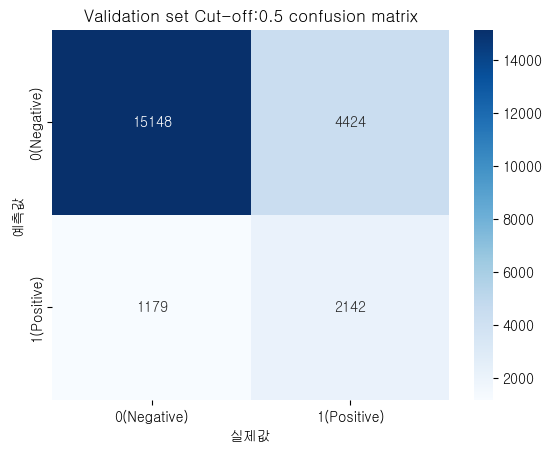

True Positive:2142
True Negative:15148
False Positive:4424
False Negative:1179


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,64.498645,62.871151,66.126139
1,Specificity,77.396280,76.810293,77.982268
2,Accuracy,75.525270,74.968328,76.082212
3,PPV,32.622601,31.488578,33.756625
4,NPV,92.778833,92.381796,93.175870
5,F_0.5_score,36.200777,NaN,NaN


In [22]:
# cut-off 0.5 validation set
cm = confusion_matrix(test_copy['TARGET1'], test_copy['prob_5'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Validation set Cut-off:0.5 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(test_copy[(test_copy['prob_5']==1)&(test_copy['TARGET1']==1)])}")
print(f"True Negative:{len(test_copy[(test_copy['prob_5']==0)&(test_copy['TARGET1']==0)])}")
print(f"False Positive:{len(test_copy[(test_copy['prob_5']==1)&(test_copy['TARGET1']==0)])}")
print(f"False Negative:{len(test_copy[(test_copy['prob_5']==0)&(test_copy['TARGET1']==1)])}")

performance(TP=len(test_copy[(test_copy['prob_5']==1)&(test_copy['TARGET1']==1)]),
            TN=len(test_copy[(test_copy['prob_5']==0)&(test_copy['TARGET1']==0)]),
            FP=len(test_copy[(test_copy['prob_5']==1)&(test_copy['TARGET1']==0)]),
            FN=len(test_copy[(test_copy['prob_5']==0)&(test_copy['TARGET1']==1)]),
            BETA=0.5)

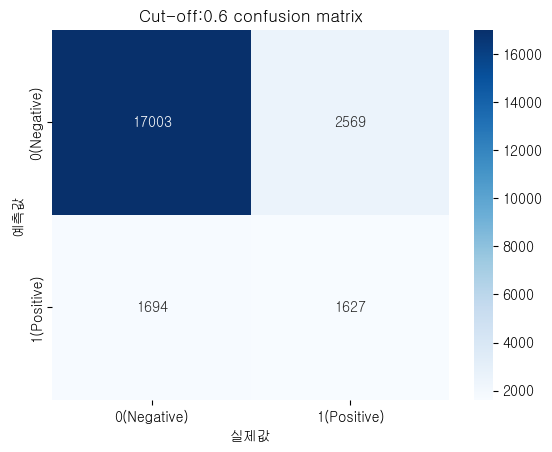

True Positive:1627
True Negative:17003
False Positive:2569
False Negative:1694


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,48.991268,47.291055,50.691480
1,Specificity,86.874106,86.401011,87.347201
2,Accuracy,81.378587,80.874314,81.882861
3,PPV,38.775024,37.300748,40.249299
4,NPV,90.939723,90.528272,91.351174
5,F_0.5_score,40.462571,NaN,NaN


In [23]:
# cut-off 0.6
cm = confusion_matrix(test_copy['TARGET1'], test_copy['prob_6'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.6 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(test_copy[(test_copy['prob_6']==1)&(test_copy['TARGET1']==1)])}")
print(f"True Negative:{len(test_copy[(test_copy['prob_6']==0)&(test_copy['TARGET1']==0)])}")
print(f"False Positive:{len(test_copy[(test_copy['prob_6']==1)&(test_copy['TARGET1']==0)])}")
print(f"False Negative:{len(test_copy[(test_copy['prob_6']==0)&(test_copy['TARGET1']==1)])}")

performance(TP=len(test_copy[(test_copy['prob_6']==1)&(test_copy['TARGET1']==1)]),
            TN=len(test_copy[(test_copy['prob_6']==0)&(test_copy['TARGET1']==0)]),
            FP=len(test_copy[(test_copy['prob_6']==1)&(test_copy['TARGET1']==0)]),
            FN=len(test_copy[(test_copy['prob_6']==0)&(test_copy['TARGET1']==1)]),
            BETA=0.5)

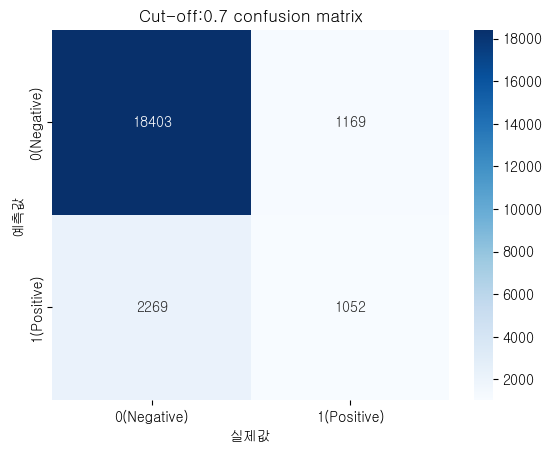

True Positive:1052
True Negative:18403
False Positive:1169
False Negative:2269


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,31.677206,30.094946,33.259466
1,Specificity,94.027182,93.695169,94.359194
2,Accuracy,84.982309,84.519533,85.445085
3,PPV,47.366051,45.289473,49.442630
4,NPV,89.023800,88.597669,89.449932
5,F_0.5_score,43.097091,NaN,NaN


In [24]:
# cut-off 0.7
cm = confusion_matrix(test_copy['TARGET1'], test_copy['prob_7'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.7 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(test_copy[(test_copy['prob_7']==1)&(test_copy['TARGET1']==1)])}")
print(f"True Negative:{len(test_copy[(test_copy['prob_7']==0)&(test_copy['TARGET1']==0)])}")
print(f"False Positive:{len(test_copy[(test_copy['prob_7']==1)&(test_copy['TARGET1']==0)])}")
print(f"False Negative:{len(test_copy[(test_copy['prob_7']==0)&(test_copy['TARGET1']==1)])}")

performance(TP=len(test_copy[(test_copy['prob_7']==1)&(test_copy['TARGET1']==1)]),
            TN=len(test_copy[(test_copy['prob_7']==0)&(test_copy['TARGET1']==0)]),
            FP=len(test_copy[(test_copy['prob_7']==1)&(test_copy['TARGET1']==0)]),
            FN=len(test_copy[(test_copy['prob_7']==0)&(test_copy['TARGET1']==1)]),
            BETA=0.5)

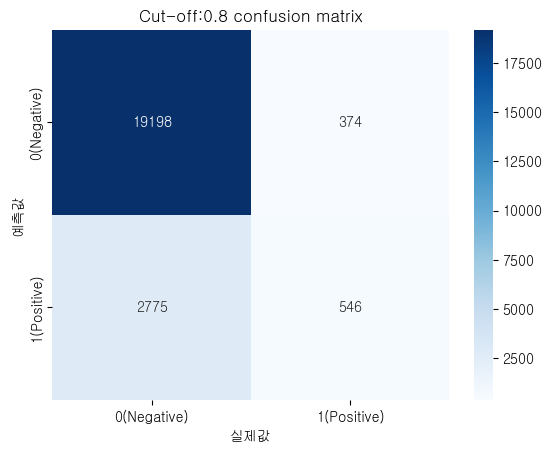

True Positive:546
True Negative:19198
False Positive:374
False Negative:2775


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,16.440831,15.180222,17.701441
1,Specificity,98.089107,97.897299,98.280915
2,Accuracy,86.244704,85.798528,86.690879
3,PPV,59.347826,56.173830,62.521823
4,NPV,87.370864,86.931645,87.810084
5,F_0.5_score,38.994429,NaN,NaN


In [25]:
# cut-off 0.8
cm = confusion_matrix(test_copy['TARGET1'], test_copy['prob_8'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.8 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(test_copy[(test_copy['prob_8']==1)&(test_copy['TARGET1']==1)])}")
print(f"True Negative:{len(test_copy[(test_copy['prob_8']==0)&(test_copy['TARGET1']==0)])}")
print(f"False Positive:{len(test_copy[(test_copy['prob_8']==1)&(test_copy['TARGET1']==0)])}")
print(f"False Negative:{len(test_copy[(test_copy['prob_8']==0)&(test_copy['TARGET1']==1)])}")

performance(TP=len(test_copy[(test_copy['prob_8']==1)&(test_copy['TARGET1']==1)]),
            TN=len(test_copy[(test_copy['prob_8']==0)&(test_copy['TARGET1']==0)]),
            FP=len(test_copy[(test_copy['prob_8']==1)&(test_copy['TARGET1']==0)]),
            FN=len(test_copy[(test_copy['prob_8']==0)&(test_copy['TARGET1']==1)]),
            BETA=0.5)

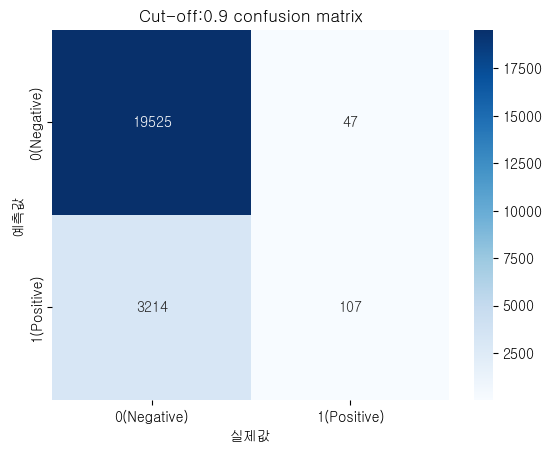

True Positive:107
True Negative:19525
False Positive:47
False Negative:3214


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,3.221921,2.621346,3.822497
1,Specificity,99.759861,99.691289,99.828433
2,Accuracy,85.755471,85.302720,86.208222
3,PPV,69.480519,62.207482,76.753557
4,NPV,85.865693,85.412882,86.318505
5,F_0.5_score,13.589027,NaN,NaN


In [26]:
# cut-off 0.9
cm = confusion_matrix(test_copy['TARGET1'], test_copy['prob_9'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.9 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(test_copy[(test_copy['prob_9']==1)&(test_copy['TARGET1']==1)])}")
print(f"True Negative:{len(test_copy[(test_copy['prob_9']==0)&(test_copy['TARGET1']==0)])}")
print(f"False Positive:{len(test_copy[(test_copy['prob_9']==1)&(test_copy['TARGET1']==0)])}")
print(f"False Negative:{len(test_copy[(test_copy['prob_9']==0)&(test_copy['TARGET1']==1)])}")

performance(TP=len(test_copy[(test_copy['prob_9']==1)&(test_copy['TARGET1']==1)]),
            TN=len(test_copy[(test_copy['prob_9']==0)&(test_copy['TARGET1']==0)]),
            FP=len(test_copy[(test_copy['prob_9']==1)&(test_copy['TARGET1']==0)]),
            FN=len(test_copy[(test_copy['prob_9']==0)&(test_copy['TARGET1']==1)]),
            BETA=0.5)

##### 0.85

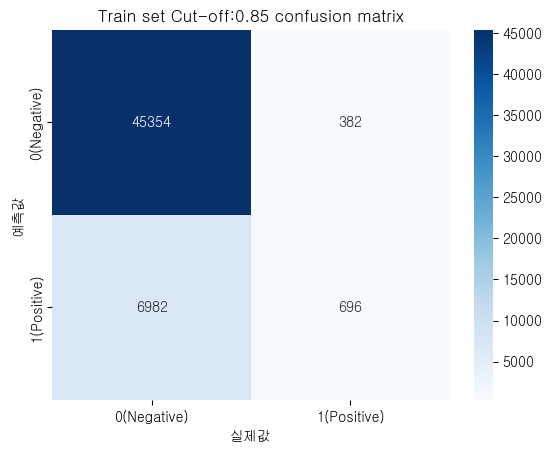

True Positive:696
True Negative:45354
False Positive:382
False Negative:6982


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,9.064861,8.422649,9.707073
1,Specificity,99.164772,99.081364,99.248180
2,Accuracy,86.213352,85.920974,86.505731
3,PPV,64.564007,61.708625,67.419390
4,NPV,86.659279,86.367970,86.950587
5,F_0.5_score,29.024187,NaN,NaN


In [27]:
# cut-off 0.85 train
cm = confusion_matrix(train_copy['TARGET1'], train_copy['prob_85'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Train set Cut-off:0.85 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(train_copy[(train_copy['prob_85']==1)&(train_copy['TARGET1']==1)])}")
print(f"True Negative:{len(train_copy[(train_copy['prob_85']==0)&(train_copy['TARGET1']==0)])}")
print(f"False Positive:{len(train_copy[(train_copy['prob_85']==1)&(train_copy['TARGET1']==0)])}")
print(f"False Negative:{len(train_copy[(train_copy['prob_85']==0)&(train_copy['TARGET1']==1)])}")

performance(TP=len(train_copy[(train_copy['prob_85']==1)&(train_copy['TARGET1']==1)]),
            TN=len(train_copy[(train_copy['prob_85']==0)&(train_copy['TARGET1']==0)]),
            FP=len(train_copy[(train_copy['prob_85']==1)&(train_copy['TARGET1']==0)]),
            FN=len(train_copy[(train_copy['prob_85']==0)&(train_copy['TARGET1']==1)]),
            BETA=0.5)

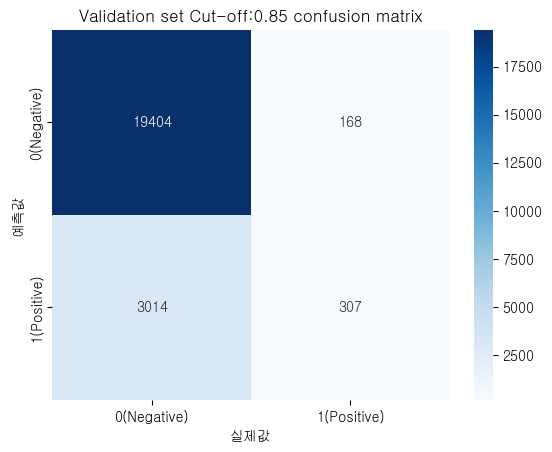

True Positive:307
True Negative:19404
False Positive:168
False Negative:3014


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,9.244204,8.259073,10.229334
1,Specificity,99.141631,99.012389,99.270873
2,Accuracy,86.100555,85.652422,86.548687
3,PPV,64.631579,60.331866,68.931292
4,NPV,86.555447,86.108888,87.002005
5,F_0.5_score,29.400498,NaN,NaN


In [28]:
# cut-off 0.85 validation
cm = confusion_matrix(test_copy['TARGET1'], test_copy['prob_85'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Validation set Cut-off:0.85 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(test_copy[(test_copy['prob_85']==1)&(test_copy['TARGET1']==1)])}")
print(f"True Negative:{len(test_copy[(test_copy['prob_85']==0)&(test_copy['TARGET1']==0)])}")
print(f"False Positive:{len(test_copy[(test_copy['prob_85']==1)&(test_copy['TARGET1']==0)])}")
print(f"False Negative:{len(test_copy[(test_copy['prob_85']==0)&(test_copy['TARGET1']==1)])}")

performance(TP=len(test_copy[(test_copy['prob_85']==1)&(test_copy['TARGET1']==1)]),
            TN=len(test_copy[(test_copy['prob_85']==0)&(test_copy['TARGET1']==0)]),
            FP=len(test_copy[(test_copy['prob_85']==1)&(test_copy['TARGET1']==0)]),
            FN=len(test_copy[(test_copy['prob_85']==0)&(test_copy['TARGET1']==1)]),
            BETA=0.5)